# Understanding the Role of Gender in Book Reviews

## CS 6471: Computational Social Science - Project
Author: Pratyusha Maiti

Affiliation: Georgia Institute of Technology

### Research Objectives
- Do book reviews by different genders differ in stylistic features?
- Do book reviews by different genders differ w.r.t their content?
- Are book reviews written by males perceived as more useful than book reviews written by females?


**Review data obtained from: https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home**

## 0. Set Up

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
!pip install contractions
!pip install tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pratyushamaiti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pratyushamaiti/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pratyushamaiti/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/pratyushamaiti/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/pratyushamaiti/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


You should consider upgrading via the '/opt/homebrew/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/homebrew/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     /Users/pratyushamaiti/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## 1. Review Data Cleaning

Parameters:
 - Expand contractions
 - Remove stopwords
 - Remove junk and html
 - Tokenize
 - Lemmatize
 

In [3]:
import contractions 
import re
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt 

Tweak the below parameters as you like. We are keeping stopwords at this point to study the use of hedge words and pronouns in the review text.

In [4]:
expand_contractions = True
remove_stopwords = False
format_text = True
tokenize = True
lemmatize = False

def clean_text(text):
    '''Text Preprocessing '''
    
    # Convert words to lower case
    text = text.lower()
    split_text = text.split()
    
    # Expand contractions
    if expand_contractions:
        expanded_words = []   
        for word in split_text:
            expanded_words.append(contractions.fix(word))
        text = " ".join(expanded_words)

    # Format words and remove unwanted characters
    if format_text:
        text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
        text = re.sub(r'\<a href', ' ', text)
        text = re.sub(r'&amp;', '', text) 
        text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
        text = re.sub(r'<br />', ' ', text)
        text = re.sub(r'\'', ' ', text)
    
    # remove stopwords
    if remove_stopwords:
        split_text = text.split()
        stops = set(stopwords.words("english"))
        word = [w for w in split_text if not w in stops]
        text = " ".join(word)

    # Tokenize each word
    if tokenize:
        text =  nltk.WordPunctTokenizer().tokenize(text)
    
    # Lemmatize each token
    if lemmatize:
        lemm = nltk.stem.WordNetLemmatizer()
        text = list(map(lambda word:list(map(lemm.lemmatize, word)), text))
    
    return text

In [5]:
import nltk
words = set(nltk.corpus.words.words())

def remove_non_english(text):
    return " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha())

### 1.1 Combine review data and gender info

The original dataset consists of anonymized names and reviews, but a mapping to the original user-id on Goodreads has been provided. Using the mapping and Goodreads API, we obtain the First Names of the reviewers and use gender_guesser to map the first names to possible genders. The final gender info is stored in goodreads_names_id_gender.csv. 


**Update(17th April) :** Gender mapping improved. 

In [6]:
import pandas as pd
gendered_data = pd.read_csv('goodreads_id_name_gender_new.csv')
gendered_data.columns = ['index', 'id', 'name', 'username', 'age', 'location', 'joined', 'friends_count','groups_count', 'reviews_count', 'first_name', 'user_id', 'gender']
gendered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852197 entries, 0 to 852196
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   index          852197 non-null  int64  
 1   id             852197 non-null  int64  
 2   name           850616 non-null  object 
 3   username       252735 non-null  object 
 4   age            242043 non-null  float64
 5   location       665382 non-null  object 
 6   joined         820599 non-null  object 
 7   friends_count  820599 non-null  float64
 8   groups_count   820599 non-null  float64
 9   reviews_count  820599 non-null  float64
 10  first_name     850555 non-null  object 
 11  user_id        852197 non-null  object 
 12  gender         797903 non-null  object 
dtypes: float64(4), int64(2), object(7)
memory usage: 84.5+ MB


### 1.2 Merge and clean the gender and review data

- Merge pd dfs for review data and gender info based on user ID
- Drop the rows where gender is unknown
- Generate a pie chart of male vs female ratio in reviews

In [8]:
import gzip
import json

def load_data(file_name, head = 500):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)
            
            # break if reaches the 100th line
            if (head is not None) and (count > head):
                break
    return data

**Load Mystery, Thriller, Crime genre reviews**

Variable _gendered_reviews_mtc_ contains data with non-empty gender field.

In [12]:
goodreads_reviews_mystery_thriller_crime = load_data('goodreads_reviews_mystery_thriller_crime.json.gz', None)
goodreads_reviews_mystery_thriller_crime_df = pd.DataFrame(goodreads_reviews_mystery_thriller_crime)

gendered_reviews_mtc = pd.merge(goodreads_reviews_mystery_thriller_crime_df, gendered_data, on='user_id', how='left')

gendered_reviews_mtc = gendered_reviews_mtc[gendered_reviews_mtc.gender != 'unknown']
gendered_reviews_mtc = gendered_reviews_mtc[gendered_reviews_mtc.gender != 'UNK']
gendered_reviews_mtc = gendered_reviews_mtc.dropna(subset=['gender'])
gendered_reviews_mtc = gendered_reviews_mtc.reset_index(drop=True)
gendered_reviews_mtc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586008 entries, 0 to 1586007
Data columns (total 23 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   user_id        1586008 non-null  object 
 1   book_id        1586008 non-null  object 
 2   review_id      1586008 non-null  object 
 3   rating         1586008 non-null  int64  
 4   review_text    1586008 non-null  object 
 5   date_added     1586008 non-null  object 
 6   date_updated   1586008 non-null  object 
 7   read_at        1586008 non-null  object 
 8   started_at     1586008 non-null  object 
 9   n_votes        1586008 non-null  int64  
 10  n_comments     1586008 non-null  int64  
 11  index          1586008 non-null  float64
 12  id             1586008 non-null  float64
 13  name           1586008 non-null  object 
 14  username       816070 non-null   object 
 15  age            724885 non-null   float64
 16  location       1141134 non-null  object 
 17  joined  

female    1174667
male       411341
Name: gender, dtype: int64


<AxesSubplot:ylabel='gender'>

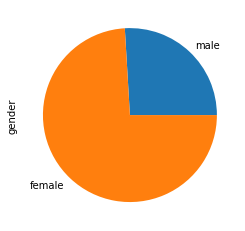

In [97]:
print(gendered_reviews_mtc['gender'].value_counts())
gendered_reviews_mtc.gender.value_counts().sort_values().plot(kind = 'pie')

**Load Fantasy, Paranormal genre reviews**

Variable _gendered_reviews_r_ contains data with non-empty gender field.

In [13]:
goodreads_reviews_romance = load_data('goodreads_reviews_fantasy_paranormal.json.gz', None)
goodreads_reviews_romance_df = pd.DataFrame(goodreads_reviews_romance)

gendered_reviews_r = pd.merge(goodreads_reviews_romance_df, gendered_data, on='user_id', how='left')

gendered_reviews_r = gendered_reviews_r[gendered_reviews_r.gender != 'unknown']
gendered_reviews_r = gendered_reviews_r[gendered_reviews_r.gender != 'UNK']
gendered_reviews_r = gendered_reviews_r.dropna(subset=['gender'])
gendered_reviews_r = gendered_reviews_r.reset_index(drop=True)
gendered_reviews_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2853419 entries, 0 to 2853418
Data columns (total 23 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   book_id        object 
 2   review_id      object 
 3   rating         int64  
 4   review_text    object 
 5   date_added     object 
 6   date_updated   object 
 7   read_at        object 
 8   started_at     object 
 9   n_votes        int64  
 10  n_comments     int64  
 11  index          float64
 12  id             float64
 13  name           object 
 14  username       object 
 15  age            float64
 16  location       object 
 17  joined         object 
 18  friends_count  float64
 19  groups_count   float64
 20  reviews_count  float64
 21  first_name     object 
 22  gender         object 
dtypes: float64(6), int64(3), object(14)
memory usage: 500.7+ MB


female    2262004
male       591415
Name: gender, dtype: int64


array([<AxesSubplot:ylabel='gender'>], dtype=object)

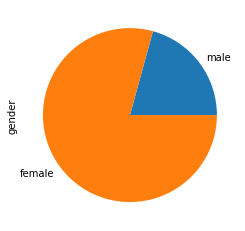

In [95]:
print(gendered_reviews_r['gender'].value_counts())
gendered_reviews_r.gender.value_counts().sort_values().plot(kind = 'pie')

**Load History, Biography genre reviews**

Variable _gendered_reviews_h_ contains data with non-empty gender field.

In [14]:
goodreads_reviews_history = load_data('goodreads_reviews_history_biography.json.gz', None)
goodreads_reviews_history_df = pd.DataFrame(goodreads_reviews_romance)

gendered_reviews_h = pd.merge(goodreads_reviews_history_df, gendered_data, on='user_id', how='left')

gendered_reviews_h = gendered_reviews_h[gendered_reviews_h.gender != 'unknown']
gendered_reviews_h = gendered_reviews_h[gendered_reviews_h.gender != 'UNK']
gendered_reviews_h = gendered_reviews_h.dropna(subset=['gender'])
gendered_reviews_h = gendered_reviews_h.reset_index(drop=True)
gendered_reviews_h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2853419 entries, 0 to 2853418
Data columns (total 23 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   book_id        object 
 2   review_id      object 
 3   rating         int64  
 4   review_text    object 
 5   date_added     object 
 6   date_updated   object 
 7   read_at        object 
 8   started_at     object 
 9   n_votes        int64  
 10  n_comments     int64  
 11  index          float64
 12  id             float64
 13  name           object 
 14  username       object 
 15  age            float64
 16  location       object 
 17  joined         object 
 18  friends_count  float64
 19  groups_count   float64
 20  reviews_count  float64
 21  first_name     object 
 22  gender         object 
dtypes: float64(6), int64(3), object(14)
memory usage: 500.7+ MB


female    2262004
male       591415
Name: gender, dtype: int64


<AxesSubplot:ylabel='gender'>

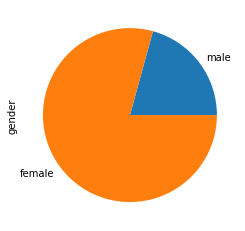

In [96]:
print(gendered_reviews_h['gender'].value_counts())
gendered_reviews_h.gender.value_counts().sort_values().plot(kind = 'pie')

**Takeaways from this section:**

### 1.3 Generate cleaned review data

- Run clean_text function on a subset of review data and use it for subsequent analysis.
- For now, we select gender balanced data of 30,000 reviews (15,000 reviews by each gender) and randomise the content

In [15]:
from tqdm import tqdm

def clean_review(reviews_set):
    pd.options.mode.chained_assignment = None
    for idx in tqdm(range(reviews_set.shape[0])):
        reviews_set['review_text'][idx] = ' '.join(clean_text(reviews_set['review_text'][idx]))

In [16]:
def remove_noneng_review(reviews_set):
    pd.options.mode.chained_assignment = None
    for idx in tqdm(range(reviews_set.shape[0])):
        reviews_set['review_text'][idx] = remove_non_english(reviews_set['review_text'][idx])

In [17]:
def generate_balanced_train_test(reviews_set, train_n, test_n):
    train_balanced_reviews, test_balanced_reviews = None, None
    
    # separate out the male and female reviews from review set
    male_reviews = reviews_set.loc[reviews_set['gender'] == "male"]
    male_reviews = male_reviews.reset_index(drop=True)
    female_reviews = reviews_set.loc[reviews_set['gender'] == "female"]
    female_reviews = female_reviews.reset_index(drop=True)

    train_frames = [male_reviews[:train_n], female_reviews[:train_n]]
    train_balanced_reviews = pd.concat(train_frames)
    train_balanced_reviews = train_balanced_reviews.reset_index(drop=True)

    test_frames = [male_reviews[train_n:train_n+test_n], female_reviews[train_n:train_n+test_n]]
    test_balanced_reviews = pd.concat(test_frames)
    test_balanced_reviews = test_balanced_reviews.reset_index(drop=True)

    #shuffle the reviews
    train_balanced_reviews.reindex(np.random.permutation(train_balanced_reviews.index))
    test_balanced_reviews.reindex(np.random.permutation(test_balanced_reviews.index))
    
    return train_balanced_reviews, test_balanced_reviews

**Mystery, Thriller, Crime**

In [18]:
train_balanced_reviews_mtc, test_balanced_reviews_mtc = generate_balanced_train_test(gendered_reviews_mtc, 100000, 10000)

clean_review(train_balanced_reviews_mtc)
clean_review(test_balanced_reviews_mtc)
remove_noneng_review(train_balanced_reviews_mtc)
remove_noneng_review(test_balanced_reviews_mtc)

100%|██████████| 20000/20000 [00:05<00:00, 3768.44it/s]


In [104]:
cols = []
for col in train_balanced_reviews_mtc.columns:
    cols += [col]
print ("List in proper method", '[%s]' % ', '.join(map(str, cols)))

List in proper method [user_id, book_id, review_id, rating, review_text, date_added, date_updated, read_at, started_at, n_votes, n_comments, index, id, name, username, age, location, joined, friends_count, groups_count, reviews_count, first_name, gender]


In [112]:
train_file_name = "train_mtc.csv"
test_file_name = "test_mtc.csv"
train_balanced_reviews_mtc.to_csv(train_file_name, sep='\t')
test_balanced_reviews_mtc.to_csv(test_file_name, sep='\t')

**Fantasy, Paranormal**

In [19]:
train_balanced_reviews_r, test_balanced_reviews_r = generate_balanced_train_test(gendered_reviews_r, 100000, 10000)

clean_review(train_balanced_reviews_r)
clean_review(test_balanced_reviews_r)
remove_noneng_review(train_balanced_reviews_r)
remove_noneng_review(test_balanced_reviews_r)

100%|██████████| 20000/20000 [00:05<00:00, 3471.92it/s]


In [110]:
train_file_name = "train_r.csv"
test_file_name = "test_r.csv"
train_balanced_reviews_r.to_csv(train_file_name, sep='\t')
test_balanced_reviews_r.to_csv(test_file_name, sep='\t')

**History, Biography**

In [20]:
train_balanced_reviews_h, test_balanced_reviews_h = generate_balanced_train_test(gendered_reviews_h, 100000, 10000)

clean_review(train_balanced_reviews_h)
clean_review(test_balanced_reviews_h)
remove_noneng_review(train_balanced_reviews_h)
remove_noneng_review(test_balanced_reviews_h)

100%|██████████| 20000/20000 [00:05<00:00, 3493.00it/s]


In [111]:
train_file_name = "train_h.csv"
test_file_name = "test_h.csv"
train_balanced_reviews_h.to_csv(train_file_name, sep='\t')
test_balanced_reviews_h.to_csv(test_file_name, sep='\t')

0         this is a special book it slow for about the f...
1         a beautiful story is truly a unique storytelle...
2         mark is a steely eyed missile man a man s man ...
3         a fun fast paced book that you in right away a...
4         this book a great premise and is full of some ...
                                ...                        
199995    i admit freely that i am not a fan of this gen...
199996    rice her magic pen and us completely in a wove...
199997    rice is as brilliant and clever as ever provin...
199998                            you can read my review on
199999    i the first book the this felt like a middle b...
Name: review_text, Length: 200000, dtype: object

In [144]:
train_balanced_reviews_h

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,...,name,username,age,location,joined,friends_count,groups_count,reviews_count,first_name,gender
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,this is a special book it slow for about the f...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,...,Otis Chandler,otis,44.0,"San Francisco, CA",08/2006,2032.0,125.0,1312.0,otis,male
1,8842281e1d1347389f2ab93d60773d4d,5577844,52c8ac49496c153e4a97161e36b2db55,5,a beautiful story is truly a unique storytelle...,Wed Sep 24 09:29:29 -0700 2014,Wed Oct 01 00:31:56 -0700 2014,Tue Sep 30 00:00:00 -0700 2014,Sun Sep 21 00:00:00 -0700 2014,5,...,Otis Chandler,otis,44.0,"San Francisco, CA",08/2006,2032.0,125.0,1312.0,otis,male
2,8842281e1d1347389f2ab93d60773d4d,17315048,885c772fb033b041f42d57cef5be0a43,5,mark is a steely eyed missile man a man s man ...,Sat Apr 05 09:30:53 -0700 2014,Wed Mar 22 11:33:10 -0700 2017,Mon Aug 25 00:00:00 -0700 2014,Sat Aug 16 00:00:00 -0700 2014,25,...,Otis Chandler,otis,44.0,"San Francisco, CA",08/2006,2032.0,125.0,1312.0,otis,male
3,8842281e1d1347389f2ab93d60773d4d,13453029,46a6e1a14e8afc82d221fec0a2bd3dd0,4,a fun fast paced book that you in right away a...,Tue Dec 04 11:12:22 -0800 2012,Sat Jul 26 11:43:28 -0700 2014,Tue Jul 08 00:00:00 -0700 2014,Wed Jul 02 00:00:00 -0700 2014,5,...,Otis Chandler,otis,44.0,"San Francisco, CA",08/2006,2032.0,125.0,1312.0,otis,male
4,8842281e1d1347389f2ab93d60773d4d,13239822,a582bfa8efd69d453a5a21a678046b36,3,this book a great premise and is full of some ...,Mon Jul 02 16:04:16 -0700 2012,Wed Mar 22 11:32:20 -0700 2017,Wed Aug 15 00:00:00 -0700 2012,Sun Aug 12 00:00:00 -0700 2012,7,...,Otis Chandler,otis,44.0,"San Francisco, CA",08/2006,2032.0,125.0,1312.0,otis,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,898c6deb68d850577e9c59daa1847958,15715110,4100d14f9bc628fbf8ee012c7399d5f6,3,i admit freely that i am not a fan of this gen...,Sun Aug 12 14:43:44 -0700 2012,Sun Aug 12 15:11:04 -0700 2012,Sat Aug 11 00:00:00 -0700 2012,,5,...,Carolyn Seiver,Lunas_Grace,NaN,NaN,07/2012,64.0,2.0,108.0,carolyn,female
199996,898c6deb68d850577e9c59daa1847958,11901,5388a36f655dc9f74a2274996b3737a5,5,rice her magic pen and us completely in a wove...,Sat Jul 28 22:00:13 -0700 2012,Fri Oct 12 12:40:27 -0700 2012,Fri Oct 12 12:40:27 -0700 2012,Mon Sep 24 00:00:00 -0700 2012,0,...,Carolyn Seiver,Lunas_Grace,NaN,NaN,07/2012,64.0,2.0,108.0,carolyn,female
199997,898c6deb68d850577e9c59daa1847958,119093,c39414399e60f588538884a72b69d563,4,rice is as brilliant and clever as ever provin...,Sat Jul 28 21:42:44 -0700 2012,Sat Sep 29 11:31:23 -0700 2012,Tue Sep 18 00:00:00 -0700 2012,,8,...,Carolyn Seiver,Lunas_Grace,NaN,NaN,07/2012,64.0,2.0,108.0,carolyn,female
199998,898c6deb68d850577e9c59daa1847958,13579021,1ba5d80168c1e175a3809f843d2d2b88,5,you can read my review on,Sat Jul 28 21:32:53 -0700 2012,Sat Jul 28 21:34:15 -0700 2012,Fri Jun 01 00:00:00 -0700 2012,,1,...,Carolyn Seiver,Lunas_Grace,NaN,NaN,07/2012,64.0,2.0,108.0,carolyn,female


In [21]:
# #load from saved files

# import pandas as pd

# train_balanced_reviews_mtc = pd.read_csv("train_mtc.csv")
# train_balanced_reviews_r = pd.read_csv("train_r.csv")
# train_balanced_reviews_h = pd.read_csv("train_h.csv")

# test_balanced_reviews_mtc = pd.read_csv("test_mtc.csv")
# test_balanced_reviews_r = pd.read_csv("test_r.csv")
# test_balanced_reviews_h = pd.read_csv("test_h.csv")

#### Exploratory analysis

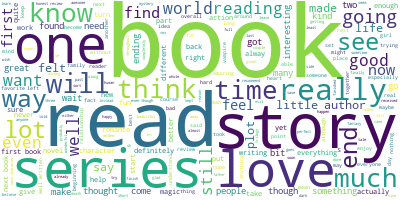

In [107]:
#what do female reviews look like?
df = train_balanced_reviews_r.loc[train_balanced_reviews_mtc['gender'] == "female"]
female_reviews = ','.join(list(df['review_text'].values))
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
wordcloud.generate(female_reviews)
wordcloud.to_image()

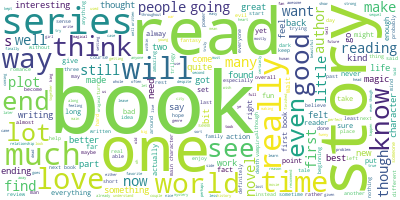

In [108]:
df = train_balanced_reviews_r.loc[train_balanced_reviews_mtc['gender'] == "male"]
male_reviews = ','.join(list(df['review_text'].values))
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
wordcloud.generate(male_reviews)
wordcloud.to_image()

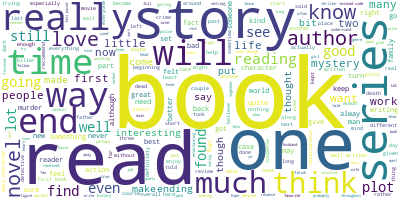

In [29]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(train_balanced_reviews_mtc['review_text'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

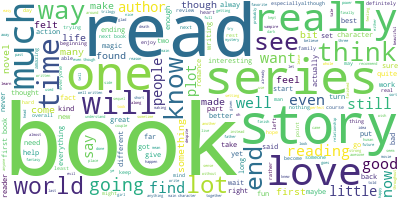

In [30]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(train_balanced_reviews_r['review_text'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

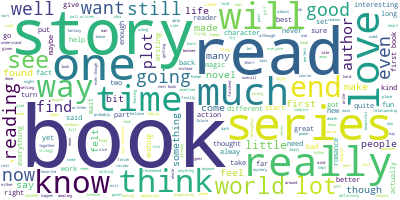

In [31]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(train_balanced_reviews_h['review_text'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [21]:
print(len(long_string))

145336816


## 2. Model Setup

- Logistic Regression model for analysing performance in predicting gender 
- Metrics used to measure performance:
    - Accuracy
    - Log Odds?
    - MSE
    - RMSE
    
The values output for metrics in this section are default values taking a dummy feature set of all zeroes.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss,accuracy_score
import sklearn.metrics as metrics

In [23]:
a = np.zeros(shape=(40000, 1))
feature_df = pd.DataFrame(a,columns=['dummy'])

In [23]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    logLoss = metrics.log_loss(y_true, y_pred)
#     f1=metrics.f1_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('log loss: ', round(logLoss,4)) 
#     print('f1: ', round(f1,4))
#     print('MAE: ', round(mean_absolute_error,4))
#     print('MSE: ', round(mse,4))
#     print('RMSE: ', round(np.sqrt(mse),4))

In [80]:
def call_model(train_set, test_set):
    Y_train=[0 if gender=="male" else 1 for gender in train_set['gender'].values]
    Y_test=[0 if gender=="male" else 1 for gender in test_set['gender'].values]

    scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=10000)
    model=scikit_log_reg.fit(feature_df[:200000],Y_train)

    predicted = model.predict(feature_df[200000:])
    probs = model.predict_proba(feature_df[200000:])
    
#     pprint(model.summary())
    
    #decision confidence
    confidence = model.decision_function(feature_df[200000:])
    print(confidence)
      
    #odds ratio
    odds_ratio=pd.DataFrame({'odds_ratio':(np.exp(model.coef_).T).tolist(),'variable':feature_df.columns.tolist()})
    odds_ratio['odds_ratio'] = odds_ratio['odds_ratio'].str.get(0)
    odds_ratio=odds_ratio.sort_values('odds_ratio', ascending=False)
    print(odds_ratio)

#     y_test_n = [0 if y == "male" else 1 for y in Y_test]
    y_test_n = Y_test
    probs_n = [i[0] for i in probs]
    print("Model %s vs Gender" % (feature_df.columns[0]))
    print(("Accuracy  ") + str(accuracy_score(Y_test, predicted)))
    plt.plot(probs_n, feature_df[200000:]) 
    plt.xlabel("Prediction Probability")
    plt.ylabel("Feature Values")
    return regression_results(y_test_n, probs_n)


In [62]:
# y_train = [1]*len(train_balanced_reviews_mtc)
y_train = [0 if gender=="male" else 1 for gender in train_balanced_reviews_mtc['gender'].values]
print(y_train.count(1))
# print(train_balanced_reviews_mtc['gender'].count('female'))
# print(y_train)

100000


In [53]:
train_balanced_reviews_mtc['gender'].values

array(['male', 'male', 'male', ..., 'female', 'female', 'female'],
      dtype=object)

In [26]:
def call_model_2(train_set, test_set):
    Y_train=train_set['gender'].values
    Y_test=test_set['gender'].values

    scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=20000)
    model=scikit_log_reg.fit(feature_df[:200000],Y_train)

    predicted = model.predict(feature_df[200000:])
    probs = model.predict_proba(feature_df[200000:])

    y_test_n = [0 if y == "male" else 1 for y in Y_test]
    probs_n = [i[0] for i in probs]
    print("Model %s vs Gender" % (feature_df.columns[0]))
    print(("Accuracy  ") + str(accuracy_score(Y_test, predicted)))
    plt.plot(probs_n, feature_df[200000:]) 
    plt.xlabel("Prediction Probability")
    plt.ylabel("Feature Values")
    return regression_results(y_test_n, probs_n)


In [52]:
call_model(gendered_reviews_mtc)

TypeError: call_model() missing 1 required positional argument: 'test_set'

## 3. Writing Style Analysis

#### Features under analysis:
- lexical_markers 
- vocabulary_richness
- complexity 
- hedging
- use_of_pronouns


In [25]:
from collections import Counter
from nltk.probability import FreqDist
import math 
from nltk.tokenize import sent_tokenize
from nltk import word_tokenize, pos_tag

def get_pronouns(reviews_set):
    pos_pronouns = []
    for idx in tqdm(range(reviews_set.shape[0])):
        if len(reviews_set['review_text'][idx])>0:
            pos_pronouns.append(sum(1 for word, pos in pos_tag(word_tokenize(reviews_set['review_text'][idx])) if pos.startswith('PR') or word == "i"))
        else:
            pos_pronouns.append(0)
#     print(len(pos_pronouns))
    return pos_pronouns

def avg_wordLength(text):
    return np.average([len(word) for word in text.split()])

def avg_SentLenghtByCh(text):
    tokens = sent_tokenize(text)
    return np.average([len(token) for token in tokens])

def avg_SentLenghtByWord(text):
    tokens = sent_tokenize(text)
    return np.average([len(token.split()) for token in tokens])

def get_complexity(reviews_set):
    complexity_1 = []
    complexity_2 = []
    complexity_3 = []
    for idx in tqdm(range(reviews_set.shape[0])):
        if len(reviews_set['review_text'][idx])>0:
            complexity_1.append(avg_wordLength(reviews_set['review_text'][idx]))
            complexity_2.append(avg_SentLenghtByCh(reviews_set['review_text'][idx]))
            complexity_3.append(avg_SentLenghtByWord(reviews_set['review_text'][idx]))  
        else:
            complexity_1.append(0)
            complexity_2.append(0)
            complexity_3.append(0)
#     print(len(complexity_1), len(complexity_2), len(complexity_3))
    return complexity_1, complexity_2, complexity_3

def topN_Freq(data, n: int):
    fdist = FreqDist(data)
    return fdist.most_common(n)

def top_50_words(reviews_set):
    top_50 = {}
    dic2 = {}
    for idx in tqdm(range(reviews_set.shape[0])):

        freqDict = topN_Freq(reviews_set['review_text'][idx].split(), 50)
        dic1 = dict(freqDict)
        if idx != 0:
            top_50 = {k: dic1.get(k, 0) + dic2.get(k, 0) for k in set(dic1) | set(dic2)}
        dic2 = dict(Counter(top_50).most_common(50))
#     print(len(top_50))
    return dict(Counter(top_50).most_common(50))

def get_lexical_markers(reviews_set, parent_set):
    lexical_markers = []
    top_50 = top_50_words(parent_set)
    
    for idx in tqdm(range(reviews_set.shape[0])):
        freq = Counter(reviews_set['review_text'][idx].split())
        lexical_markers.append(sum(freq.get(k, 0) for k in set(top_50)))
#     print(len(lexical_markers))
    return lexical_markers

def get_hedge_words(reviews_set):
    hedgefile = open("hedgeWords.txt", "r")
    content = hedgefile.read()
    hedgeWords = content.split("\n")
    hedgefile.close()
    hedging = []
    for idx in tqdm(range(reviews_set.shape[0])):
        hedging.append(sum(1 for x in word_tokenize(reviews_set['review_text'][idx]) if x in hedgeWords))
#     print(len(hedging))
    return hedging

def yulesCharacteristicK(words):
    N = len(words)
    K=0
    if N>0:
        freqs = Counter()
        freqs.update(words)
        vi = Counter()
        vi.update(freqs.values())
        M = sum([(value * value) * vi[value] for key, value in freqs.items()])
        K = 10000 * (M - N) / math.pow(N, 2)
    return K

def get_vocabulary_richness(reviews_set):
    vocabulary_richness = []
    for idx in tqdm(range(reviews_set.shape[0])):
        vocabulary_richness.append(yulesCharacteristicK(reviews_set['review_text'][idx]))
#     print(len(vocabulary_richness))
    return vocabulary_richness



In [26]:
f_lexical_markers = []
f_lexical_markers.extend(get_lexical_markers(train_balanced_reviews_mtc, train_balanced_reviews_mtc))
f_lexical_markers.extend(get_lexical_markers(test_balanced_reviews_mtc, train_balanced_reviews_mtc))

f_hedging = []
f_hedging.extend(get_hedge_words(train_balanced_reviews_mtc))
f_hedging.extend(get_hedge_words(test_balanced_reviews_mtc))

f_vocabulary_richness = []
f_vocabulary_richness.extend(get_vocabulary_richness(train_balanced_reviews_mtc))
f_vocabulary_richness.extend(get_vocabulary_richness(test_balanced_reviews_mtc))

complexity_1, complexity_2, complexity_3 = get_complexity(train_balanced_reviews_mtc)
complexity_1_t, complexity_2_t, complexity_3_t = get_complexity(test_balanced_reviews_mtc)
complexity_1.extend(complexity_1_t)
complexity_2.extend(complexity_2_t)
complexity_3.extend(complexity_3_t)

f_pronouns = []
f_pronouns.extend(get_pronouns(train_balanced_reviews_mtc))
f_pronouns.extend(get_pronouns(test_balanced_reviews_mtc))

100%|██████████| 20000/20000 [1:44:38<00:00,  3.19it/s]  


In [100]:
# f_pronouns

In [47]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220000 entries, 0 to 219999
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   Pronouns  220000 non-null  int64
dtypes: int64(1)
memory usage: 1.7 MB


In [111]:
def generate_writing_style_feature_set(feature_df):
    f_lexical = True
    f_complexity = True
    f_vocab_richness = True
    f_hedg = True
    f_pron = True
    if f_lexical:
        feature_df['Lexical Markers'] = f_lexical_markers
    if f_complexity:
        feature_df['Complecity'] = complexity_1
        feature_df['comp2'] = complexity_2
        feature_df['comp3'] = complexity_3
    if f_vocab_richness:
        feature_df['Vocab Richness'] = f_vocabulary_richness
    if f_hedg:
        feature_df['Hedging'] = f_hedging
    if f_pron:
        feature_df['Pronouns'] = f_pronouns

[LibLinear][-0.39577068 -0.62007947 -0.08920087 ...  0.0313438   0.11539106
 -0.01296296]
   odds_ratio         variable
6    1.067036         Pronouns
5    1.014132          Hedging
0    1.011269  Lexical Markers
1    1.002343       Complecity
2    1.000545            comp2
4    1.000019   Vocab Richness
3    0.984475            comp3
Model Lexical Markers vs Gender
Accuracy  0.5666
explained_variance:  -0.0564
mean_squared_log_error:  0.1295
r2:  -0.0564
log loss:  0.724


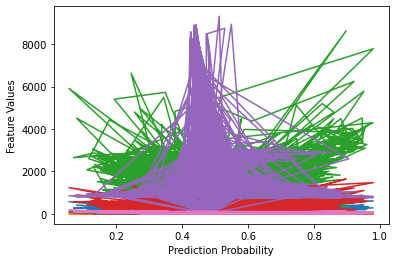

In [112]:
feature_df = pd.DataFrame() 
generate_writing_style_feature_set(feature_df)
call_model(train_balanced_reviews_mtc, test_balanced_reviews_mtc)

### Genre: Fantasy, Paranormal

In [27]:
r_lexical_markers = []
r_lexical_markers.extend(get_lexical_markers(train_balanced_reviews_r, train_balanced_reviews_r))
r_lexical_markers.extend(get_lexical_markers(test_balanced_reviews_r, train_balanced_reviews_r))

r_hedging = []
r_hedging.extend(get_hedge_words(train_balanced_reviews_r))
r_hedging.extend(get_hedge_words(test_balanced_reviews_r))

r_vocabulary_richness = []
r_vocabulary_richness.extend(get_vocabulary_richness(train_balanced_reviews_r))
r_vocabulary_richness.extend(get_vocabulary_richness(test_balanced_reviews_r))

r_complexity_1, r_complexity_2, r_complexity_3 = get_complexity(train_balanced_reviews_r)
r_complexity_1_t, r_complexity_2_t, r_complexity_3_t = get_complexity(test_balanced_reviews_r)
r_complexity_1.extend(r_complexity_1_t)
r_complexity_2.extend(r_complexity_2_t)
r_complexity_3.extend(r_complexity_3_t)

r_pronouns = []
r_pronouns.extend(get_pronouns(train_balanced_reviews_r))
r_pronouns.extend(get_pronouns(test_balanced_reviews_r))

100%|██████████| 20000/20000 [01:04<00:00, 310.63it/s]


In [113]:
def generate_writing_style_feature_set(feature_df):
    f_lexical = True
    f_complexity = True
    f_vocab_richness = True
    f_hedg = True
    f_pron = True
    if f_lexical:
        feature_df['Lexical Markers'] = r_lexical_markers
    if f_complexity:
        feature_df['Complecity'] = r_complexity_1
        feature_df['comp2'] = r_complexity_2
        feature_df['comp3'] = r_complexity_3
    if f_vocab_richness:
        feature_df['Vocab Richness'] = r_vocabulary_richness
    if f_hedg:
        feature_df['Hedging'] = r_hedging
    if f_pron:
        feature_df['Pronouns'] = r_pronouns

[LibLinear][ 0.0478958   0.04944172  0.42550808 ... -0.37673334 -0.14664035
 -0.9540585 ]
   odds_ratio         variable
6    1.048288         Pronouns
0    1.009803  Lexical Markers
4    1.000008   Vocab Richness
2    0.998532            comp2
3    0.997771            comp3
5    0.995160          Hedging
1    0.969662       Complecity
Model Lexical Markers vs Gender
Accuracy  0.541
explained_variance:  -0.0499
mean_squared_log_error:  0.1292
r2:  -0.05
log loss:  0.7269


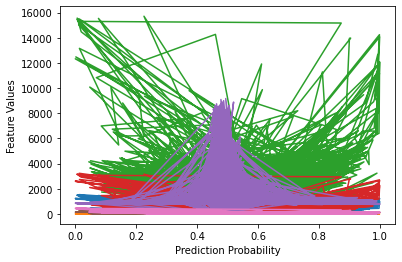

In [114]:
# test with newton-cg solver and with romance data

feature_df = pd.DataFrame() 
generate_writing_style_feature_set(feature_df)
call_model(train_balanced_reviews_r, test_balanced_reviews_r)

In [44]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220000 entries, 0 to 219999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Lexical Markers  220000 non-null  int64  
 1   Complecity       220000 non-null  float64
 2   comp2            220000 non-null  float64
 3   comp3            220000 non-null  float64
 4   Vocab Richness   220000 non-null  float64
 5   Hedging          220000 non-null  int64  
 6   Pronouns         220000 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 11.7 MB


In [85]:
# import statsmodels.api as sm
# y_train = train_balanced_reviews_r['gender'].values
# x_train = feature_df[:200000]
# logit_model=sm.Logit(y_train,x_train)
# result=logit_model.fit()
# print(result.summary())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/homebrew/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/opt/homebrew/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[ 0.36116475  0.68903877  0.04418279 ... -0.13176007 -0.07722394
 -0.06621787]
   odds_ratio         variable
1    1.100232       Complecity
3    1.006797            comp3
0    1.004902  Lexical Markers
4    0.999945   Vocab Richness
2    0.999593            comp2
5    0.993438          Hedging
6    0.939842         Pronouns
Model Lexical Markers vs Gender
Accuracy  0.552
explained_variance:  0.0114
mean_squared_log_error:  0.1223
r2:  0.0114
log loss:  0.6886


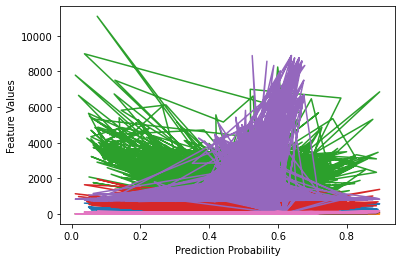

In [83]:
# test with newton-cg solver

feature_df = pd.DataFrame() 
generate_writing_style_feature_set(feature_df)
call_model(train_balanced_reviews_mtc, test_balanced_reviews_mtc)

[LibLinear]Model Lexical Markers vs Gender
Accuracy  0.5116
explained_variance:  0.0037
mean_squared_log_error:  0.1233
r2:  0.0037
log loss:  0.6913


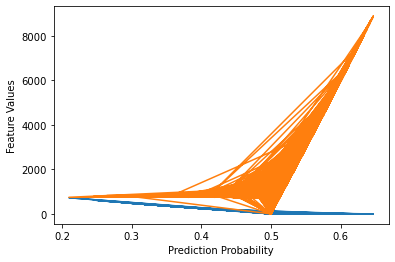

In [64]:
feature_df = pd.DataFrame() 
generate_writing_style_feature_set(feature_df)
call_model_2(train_balanced_reviews_mtc, test_balanced_reviews_mtc)

## genre: history, biography

In [28]:
h_lexical_markers = []
h_lexical_markers.extend(get_lexical_markers(train_balanced_reviews_h, train_balanced_reviews_h))
h_lexical_markers.extend(get_lexical_markers(test_balanced_reviews_h, train_balanced_reviews_h))

h_hedging = []
h_hedging.extend(get_hedge_words(train_balanced_reviews_h))
h_hedging.extend(get_hedge_words(test_balanced_reviews_h))

h_vocabulary_richness = []
h_vocabulary_richness.extend(get_vocabulary_richness(train_balanced_reviews_h))
h_vocabulary_richness.extend(get_vocabulary_richness(test_balanced_reviews_h))

h_complexity_1, h_complexity_2, h_complexity_3 = get_complexity(train_balanced_reviews_h)
h_complexity_1_t, h_complexity_2_t, h_complexity_3_t = get_complexity(test_balanced_reviews_h)
h_complexity_1.extend(h_complexity_1_t)
h_complexity_2.extend(h_complexity_2_t)
h_complexity_3.extend(h_complexity_3_t)

h_pronouns = []
h_pronouns.extend(get_pronouns(train_balanced_reviews_h))
h_pronouns.extend(get_pronouns(test_balanced_reviews_h))

100%|██████████| 20000/20000 [01:03<00:00, 312.76it/s]


In [112]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220000 entries, 0 to 219999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Lexical Markers  220000 non-null  int64  
 1   Complecity       220000 non-null  float64
 2   comp2            220000 non-null  float64
 3   comp3            220000 non-null  float64
 4   Vocab Richness   220000 non-null  float64
 5   Hedging          220000 non-null  int64  
 6   Pronouns         220000 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 11.7 MB


In [118]:
def generate_writing_style_feature_set(feature_df):
    f_lexical = True
    f_complexity = False
    f_vocab_richness = True
    f_hedg = True
    f_pron = True
    if f_lexical:
        feature_df['Lexical Markers'] = h_lexical_markers
    if f_complexity:
        feature_df['Complecity'] = h_complexity_1
        feature_df['comp2'] = h_complexity_2
        feature_df['comp3'] = h_complexity_3
    if f_vocab_richness:
        feature_df['Vocab Richness'] = h_vocabulary_richness
    if f_hedg:
        feature_df['Hedging'] = h_hedging
    if f_pron:
        feature_df['Pronouns'] = h_pronouns

[LibLinear][ 0.02559208 -0.03579354  0.32795261 ... -0.31273013 -0.19724098
 -0.616149  ]
   odds_ratio         variable
3    1.055053         Pronouns
1    1.000010   Vocab Richness
2    0.991772          Hedging
0    0.989523  Lexical Markers
Model Lexical Markers vs Gender
Accuracy  0.53835
explained_variance:  -0.0437
mean_squared_log_error:  0.1283
r2:  -0.0437
log loss:  0.7222


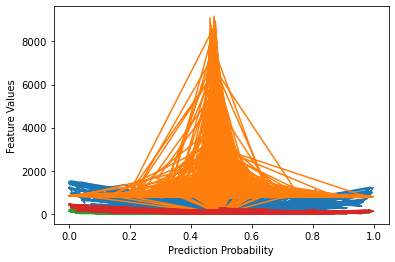

In [119]:
# test with newton-cg solver and with history data

feature_df = pd.DataFrame() 
generate_writing_style_feature_set(feature_df)
call_model(train_balanced_reviews_h, test_balanced_reviews_h)

### 3.1 Single features vs gender prediction

#### 3.1.1 Only Lexical Markers

In [44]:
feature_df = pd.DataFrame() 
generate_writing_style_feature_set(feature_df)
call_model()

TypeError: call_model() missing 2 required positional arguments: 'train_set' and 'test_set'

#### 3.1.2 Only pronouns

[LibLinear]Model Pronouns vs Gender
Accuracy  0.548
explained_variance:  0.0052
mean_squared_log_error:  0.1224
r2:  0.005
log loss:  0.6909


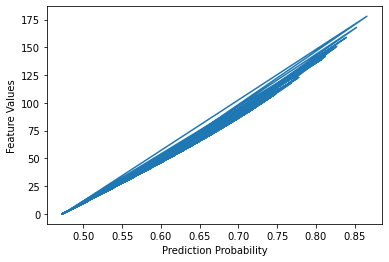

In [128]:
feature_df = pd.DataFrame() 
generate_writing_style_feature_set(feature_df)
call_model()

#### 3.1.3 Only hedging

[LibLinear]Model Hedging vs Gender
Accuracy  0.5407
explained_variance:  0.0015
mean_squared_log_error:  0.1231
r2:  0.0014
log loss:  0.6925


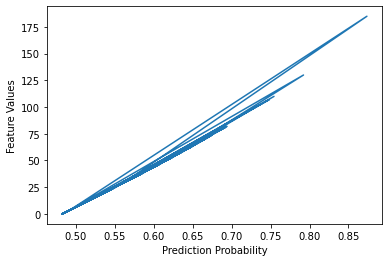

In [130]:
feature_df = pd.DataFrame() 
generate_writing_style_feature_set(feature_df)
call_model()

#### 3.1.4 Only vocab richness

[LibLinear]Model Vocab Richness vs Gender
Accuracy  0.4735
explained_variance:  -0.0005
mean_squared_log_error:  0.1236
r2:  -0.0005
log loss:  0.6934


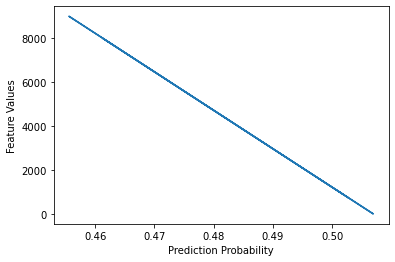

In [134]:
feature_df = pd.DataFrame() 
generate_writing_style_feature_set(feature_df)
call_model()

#### 3.1.5 Only complexity

[LibLinear]Model Complecity vs Gender
Accuracy  0.5338
explained_variance:  0.0037
mean_squared_log_error:  0.1226
r2:  0.0035
log loss:  0.6916


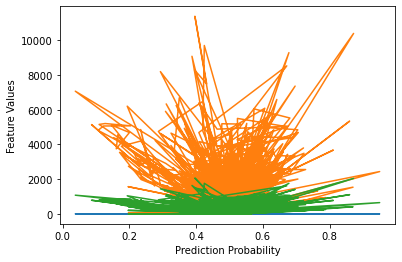

In [132]:
feature_df = pd.DataFrame() 
generate_writing_style_feature_set(feature_df)
call_model()

### 3.2 Combination of features vs gender prediction

## 4. Content Analysis

#### Features under analysis:
- Shannon Entropy: uniqueness of text
- Simpson Index: diversity in text
- Brunet’s Index: lexical richness 


In [84]:
import scipy as sc

def ShannonEntropy(words):
    if len(words) == 0:
        return 0
    freqs = Counter()
    freqs.update(words)
    arr = np.array(list(freqs.values()))
    distribution = 1. * arr
    distribution /= max(1, len(words))
    
    H = sc.stats.entropy(distribution, base=2)
    return H

def SimpsonsIndex(words):
    if len(words) < 2:
        return 0
    freqs = Counter()
    freqs.update(words)
    N = len(words)
    n = sum([1.0 * i * (i - 1) for i in freqs.values()])
    D = 1 - (n / (N * (N - 1)))
    return D

def BrunetsMeasureW(words):
    if len(words) < 2:
        return 0
    a = 0.17
    V = float(len(set(words)))
    N = len(words)
    B = (V - a) / (math.log(N))
    return B

entropy = []
simpsons = []
brunets = []

for idx in tqdm(range(train_balanced_reviews_mtc.shape[0])):
    entropy.append(ShannonEntropy(train_balanced_reviews_mtc['review_text'][idx]))
    simpsons.append(SimpsonsIndex(train_balanced_reviews_mtc['review_text'][idx]))
    brunets.append(BrunetsMeasureW(train_balanced_reviews_mtc['review_text'][idx]))

for idx in tqdm(range(test_balanced_reviews_mtc.shape[0])):
    entropy.append(ShannonEntropy(test_balanced_reviews_mtc['review_text'][idx]))
    simpsons.append(SimpsonsIndex(test_balanced_reviews_mtc['review_text'][idx]))
    brunets.append(BrunetsMeasureW(test_balanced_reviews_mtc['review_text'][idx]))
        
len(entropy), len(simpsons), len(brunets)

100%|██████████| 20000/20000 [00:01<00:00, 12880.17it/s]


(220000, 220000, 220000)

In [129]:
def generate_content_feature_set(feature_df):
    f_shannon = True
    f_simpson = True
    f_brunet = True
    if f_shannon:
        feature_df['Entropy'] = h_entropy
    if f_simpson:
        feature_df['Simpsons'] = h_simpsons
    if f_brunet:
        feature_df['Brunets'] = h_brunets

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [123]:
r_entropy = []
r_simpsons = []
r_brunets = []

for idx in tqdm(range(train_balanced_reviews_r.shape[0])):
    r_entropy.append(ShannonEntropy(train_balanced_reviews_r['review_text'][idx]))
    r_simpsons.append(SimpsonsIndex(train_balanced_reviews_r['review_text'][idx]))
    r_brunets.append(BrunetsMeasureW(train_balanced_reviews_r['review_text'][idx]))

for idx in tqdm(range(test_balanced_reviews_mtc.shape[0])):
    r_entropy.append(ShannonEntropy(test_balanced_reviews_r['review_text'][idx]))
    r_simpsons.append(SimpsonsIndex(test_balanced_reviews_r['review_text'][idx]))
    r_brunets.append(BrunetsMeasureW(test_balanced_reviews_r['review_text'][idx]))

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 20000/20000 [00:01<00:00, 10471.08it/s]


In [124]:
h_entropy = []
h_simpsons = []
h_brunets = []

for idx in tqdm(range(train_balanced_reviews_r.shape[0])):
    h_entropy.append(ShannonEntropy(train_balanced_reviews_h['review_text'][idx]))
    h_simpsons.append(SimpsonsIndex(train_balanced_reviews_h['review_text'][idx]))
    h_brunets.append(BrunetsMeasureW(train_balanced_reviews_h['review_text'][idx]))

for idx in tqdm(range(test_balanced_reviews_mtc.shape[0])):
    h_entropy.append(ShannonEntropy(test_balanced_reviews_h['review_text'][idx]))
    h_simpsons.append(SimpsonsIndex(test_balanced_reviews_h['review_text'][idx]))
    h_brunets.append(BrunetsMeasureW(test_balanced_reviews_h['review_text'][idx]))

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 20000/20000 [00:01<00:00, 10687.29it/s]


### 4.1 Single Values vs Gender

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


[ 0.05656047  0.1020193  -0.00593927 ... -0.12068683 -0.04027247
 -0.04011845]
   odds_ratio  variable
0    1.461543   Entropy
2    0.790936   Brunets
1    0.689575  Simpsons
Model Entropy vs Gender
Accuracy  0.5215
explained_variance:  0.003
mean_squared_log_error:  0.1233
r2:  0.003
log loss:  0.6916


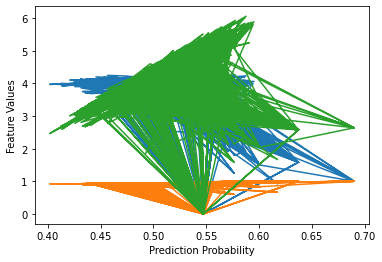

In [126]:
# Mystery, thriller, crime
feature_df = pd.DataFrame() 
generate_content_feature_set(feature_df)
call_model(train_balanced_reviews_mtc, test_balanced_reviews_mtc)

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


[-0.04059696 -0.01497976  0.02213645 ...  0.02801348  0.04385467
  0.04605733]
   odds_ratio  variable
0    1.101560   Entropy
1    0.958956  Simpsons
2    0.956655   Brunets
Model Entropy vs Gender
Accuracy  0.4945
explained_variance:  -0.0011
mean_squared_log_error:  0.1237
r2:  -0.0011
log loss:  0.6937


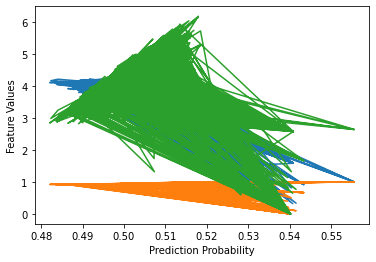

In [128]:
# Fantasy, paranormal
feature_df = pd.DataFrame() 
generate_content_feature_set(feature_df)
call_model(train_balanced_reviews_r, test_balanced_reviews_r)

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


[-0.04059696 -0.01497976  0.02213645 ...  0.02801348  0.04385467
  0.04605733]
   odds_ratio  variable
0    1.101560   Entropy
1    0.958956  Simpsons
2    0.956655   Brunets
Model Entropy vs Gender
Accuracy  0.4945
explained_variance:  -0.0011
mean_squared_log_error:  0.1237
r2:  -0.0011
log loss:  0.6937


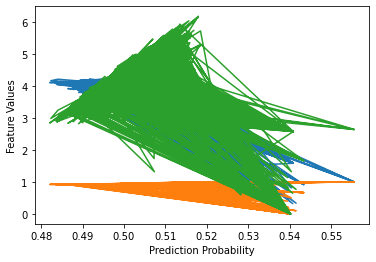

In [130]:
# History, biography
feature_df = pd.DataFrame() 
generate_content_feature_set(feature_df)
call_model(train_balanced_reviews_h, test_balanced_reviews_h)

### 4.2 Combination vs Gender

## LDA

Create 10 topics from the review data and then study occurance of topic per gender.

In [120]:
import gensim
import gensim.corpora as corpora
import pandas as pd
import os

In [121]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]




[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pratyushamaiti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
data = train_balanced_reviews_r['review_text'].values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

['special', 'book', 'slow', 'first', 'third', 'middle', 'third', 'get', 'interesting', 'last', 'third', 'mind', 'love', 'good', 'science', 'fiction', 'thinking', 'go', 'winner', 'original', 'made', 'interesting', 'different', 'way', 'read', 'instance', 'revolutionary', 'history', 'kept', 'people']


In [35]:

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 7), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1)]


In [120]:
from pprint import pprint

# number of topics
num_topics = 5

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.036*"book" + 0.016*"read" + 0.014*"love" + 0.013*"one" + 0.011*"like" + '
  '0.011*"story" + 0.010*"series" + 0.010*"really" + 0.007*"would" + '
  '0.007*"get"'),
 (1,
  '0.021*"book" + 0.010*"like" + 0.009*"read" + 0.009*"one" + 0.007*"di" + '
  '0.007*"would" + 0.006*"die" + 0.006*"harry" + 0.006*"really" + 0.005*"che"'),
 (2,
  '0.030*"book" + 0.014*"story" + 0.014*"read" + 0.013*"one" + 0.013*"like" + '
  '0.012*"really" + 0.012*"series" + 0.010*"good" + 0.009*"would" + '
  '0.008*"first"'),
 (3,
  '0.027*"de" + 0.019*"story" + 0.015*"read" + 0.012*"book" + 0.011*"la" + '
  '0.009*"en" + 0.008*"one" + 0.007*"series" + 0.007*"se" + 0.007*"great"'),
 (4,
  '0.016*"book" + 0.012*"story" + 0.009*"one" + 0.009*"world" + 0.008*"would" '
  '+ 0.007*"like" + 0.006*"much" + 0.005*"first" + 0.005*"time" + '
  '0.005*"also"')]


In [37]:
from pprint import pprint
lda_1 = gensim.models.LdaModel(corpus,id2word=id2word, num_topics=10)
pprint(lda_1.print_topics())

[(0,
  '0.069*"di" + 0.052*"non" + 0.050*"che" + 0.038*"la" + 0.033*"un" + '
  '0.029*"per" + 0.028*"sam" + 0.023*"anna" + 0.020*"mi" + 0.020*"si"'),
 (1,
  '0.137*"de" + 0.060*"en" + 0.052*"la" + 0.038*"es" + 0.036*"el" + '
  '0.032*"het" + 0.025*"lo" + 0.024*"die" + 0.024*"se" + 0.022*"un"'),
 (2,
  '0.062*"series" + 0.023*"book" + 0.021*"love" + 0.020*"favorite" + '
  '0.017*"one" + 0.015*"harry" + 0.013*"read" + 0.011*"best" + 0.010*"potter" '
  '+ 0.009*"great"'),
 (3,
  '0.064*"book" + 0.026*"read" + 0.020*"story" + 0.019*"really" + '
  '0.017*"series" + 0.016*"one" + 0.014*"like" + 0.012*"first" + 0.011*"would" '
  '+ 0.011*"reading"'),
 (4,
  '0.079*"read" + 0.076*"story" + 0.054*"fun" + 0.037*"short" + '
  '0.021*"entertaining" + 0.021*"good" + 0.020*"fairy" + 0.019*"great" + '
  '0.016*"tale" + 0.016*"vampire"'),
 (5,
  '0.021*"like" + 0.018*"book" + 0.013*"really" + 0.012*"get" + 0.012*"one" + '
  '0.012*"would" + 0.012*"know" + 0.010*"love" + 0.010*"even" + 0.009*"going"'),

In [143]:
from gensim.models import LsiModel

lsi_model = LsiModel(corpus,id2word=id2word, num_topics=10)

for topic_id in range(lsi_model.num_topics):
    topk = lsi_model.show_topic(topic_id, 10)
    topk_words = [ w for w, _ in topk ]
    
    print('{}: {}'.format(topic_id, ' '.join(topk_words)))
    
data_female = train_balanced_reviews_r_f['review_text'].values.tolist()
vector = lsi_model.id2word.doc2bow(data_female)
prob = lsi_model[vector]
pprint(prob)

data_male = train_balanced_reviews_r_m['review_text'].values.tolist()
vector = lsi_model.id2word.doc2bow(data_male)
prob = lsi_model[vector]
pprint(prob)

0: book one story like read really would series love first
1: de la en un el se es con lo para
2: book story one like would world well series even life
3: di che de la un non per si story mi
4: story like book read really would one even know love
5: series like read one really story world first book felt
6: die ist ich das read sie es den series hat
7: read series really die one world book like love ist
8: series read one would world love story really character much
9: help love yang dan la like novel world di da
[(0, 12.863727154677548),
 (1, -4.747366755800357),
 (2, 1.8891619383289466),
 (3, 0.7762707488115452),
 (4, 1.4766375446312099),
 (5, -1.6952450958990808),
 (6, -3.2909423061676537),
 (7, -8.780045106128664),
 (8, -0.8041621777696177),
 (9, -8.157936122965914)]
[(0, 16.50671652815019),
 (1, -6.828137535083079),
 (2, 1.3987566076648992),
 (3, 1.0590497087398703),
 (4, 0.3700904534667005),
 (5, -0.28142957621697917),
 (6, -3.6132767868655606),
 (7, -10.075364944954213),
 (8, -0

In [122]:
import pyLDAvis.gensim_models as gmodels
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

execute_visualisation = True

if execute_visualisation:
    LDAvis_prepared = gmodels.prepare(lda_1, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.199013 -0.022820       1        1  32.501944
5     -0.186042 -0.034873       2        1  21.689668
6     -0.167376 -0.011237       3        1  16.916234
8     -0.176160 -0.022045       4        1  10.985196
9     -0.139504 -0.005976       5        1   7.508558
2     -0.138777 -0.013445       6        1   3.523754
4     -0.028322  0.043914       7        1   2.844118
1      0.381720 -0.190193       8        1   1.989725
0      0.378544 -0.156506       9        1   1.344428
7      0.274930  0.413180      10        1   0.696376, topic_info=        Term           Freq          Total Category  logprob  loglift
85      read  129897.000000  129897.000000  Default  30.0000  30.0000
175    story  132932.000000  132932.000000  Default  29.0000  29.0000
639   series   87794.000000   87794.000000  Default  28.0000  28.0000
9       book  277906.000000  277906.000000  Default  27.0000  27.0000
2134      de   27584.000000   27584.000000  Default  26.0000  26.0000
...      ...            ...            ...      ...      ...      ...
1837  mortal    1451.798473    2106.101934  Topic10  -3.8853   4.5950
2041     kat     746.958086     896.702292  Topic10  -4.5498   4.7843
2853    bane     533.300878     581.167877  Topic10  -4.8868   4.8811
1766    city    1318.065825    6213.787038  Topic10  -3.9819   3.4164
1741    hook     600.854942    1101.442826  Topic10  -4.7675   4.3610

[739 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
2811       2  0.023226  academy
2811       4  0.144003  academy
2811       5  0.002323  academy
2811       6  0.829178  academy
793        1  0.573699   action
...      ...       ...      ...
20277      8  0.999067       zo
1418       1  0.054307   zombie
1418       2  0.094029   zombie
1418       3  0.000621   zombie
1418       5  0.850609   zombie

[2132 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 7, 9, 10, 3, 5, 2, 1, 8])

In [124]:
train_balanced_reviews_r_f = train_balanced_reviews_r.loc[train_balanced_reviews_r['gender'] == "female"]
data_female = train_balanced_reviews_r_f['review_text'].values.tolist()
vector = lda_model.id2word.doc2bow(data_female)
prob = lda_model[vector]
pprint(prob)
train_balanced_reviews_r_m = train_balanced_reviews_r.loc[train_balanced_reviews_r['gender'] == "male"]
data_male = train_balanced_reviews_r_m['review_text'].values.tolist()
vector = lda_model.id2word.doc2bow(data_male)
prob = lda_model[vector]
pprint(prob)

[(0, 0.52446324), (1, 0.03393627), (2, 0.036613397), (3, 0.4046821)]
[(0, 0.45427224), (1, 0.04771721), (2, 0.017109735), (3, 0.48063374)]


In [ ]:
lsi_model_r = LsiModel(corpus,id2word=id2word, num_topics=10)

for topic_id in range(lsi_model_r.num_topics):
    topk = lsi_model_r.show_topic(topic_id, 10)
    topk_words = [ w for w, _ in topk ]
    
    print('{}: {}'.format(topic_id, ' '.join(topk_words)))
    
data_female = train_balanced_reviews_r_f['review_text'].values.tolist()
vector = lsi_model.id2word.doc2bow(data_female)
prob = lsi_model[vector]
pprint(prob)

data_male = train_balanced_reviews_r_m['review_text'].values.tolist()
vector = lsi_model.id2word.doc2bow(data_male)
prob = lsi_model[vector]
pprint(prob)

In [73]:
for topic_id in range(lda_1.num_topics):
    topk = lda_1.show_topic(topic_id, 10)
    topk_words = [ w for w, _ in topk ]
    
    print('{}: {}'.format(topic_id, ' '.join(topk_words)))

0: di non che la un per sam anna mi si
1: de en la es el het lo die se un
2: series book love favorite one harry read best potter great
3: book read story really series one like first would reading
4: read story fun short entertaining good fairy great tale vampire
5: like book really get one would know love even going
6: story one world people also time would life novel well
7: peter emma jane faerie yang clary daemon mortal ivy city
8: love book one review find life story new read family
9: world fantasy magic novel magical adventure new well evil power


In [75]:
train_balanced_reviews_r_f = train_balanced_reviews_r.loc[train_balanced_reviews_r['gender'] == "female"]
data_female = train_balanced_reviews_r_f['review_text'].values.tolist()
vector = lda_1.id2word.doc2bow(data_female)
prob = lda_1[vector]
pprint(prob)
train_balanced_reviews_r_m = train_balanced_reviews_r.loc[train_balanced_reviews_r['gender'] == "male"]
data_male = train_balanced_reviews_r_m['review_text'].values.tolist()
vector = lda_1.id2word.doc2bow(data_male)
prob = lda_1[vector]
pprint(prob)

[(0, 0.043555386),
 (1, 0.07922274),
 (2, 0.19960211),
 (3, 0.18232462),
 (4, 0.17548203),
 (5, 0.11526289),
 (6, 0.011108001),
 (8, 0.10066245),
 (9, 0.084251784)]
[(0, 0.047546953),
 (1, 0.08700191),
 (2, 0.18745016),
 (3, 0.22948442),
 (4, 0.24686536),
 (5, 0.08253737),
 (6, 0.024298461),
 (7, 0.010198785),
 (8, 0.017610619),
 (9, 0.06700594)]


In [76]:
train_4_up = train_balanced_reviews_r.loc[train_balanced_reviews_r['rating'] >= 4]
data_4_up = train_4_up['review_text'].values.tolist()
vector_4up = lda_1.id2word.doc2bow(data_4_up)
prob_4up = lda_1[vector_4up]
pprint(prob_4up)

[(0, 0.035081595),
 (1, 0.08714069),
 (2, 0.27914423),
 (3, 0.1578939),
 (4, 0.21783485),
 (5, 0.0222394),
 (6, 0.015253681),
 (8, 0.08301361),
 (9, 0.09499164)]


In [77]:
train_5 = train_balanced_reviews_r.loc[train_balanced_reviews_r['rating'] >= 4]
train_5 = train_balanced_reviews_r.loc[train_balanced_reviews_r['n_votes']>10]
data_5 = train_5['review_text'].values.tolist()
vector_5 = lda_1.id2word.doc2bow(data_5)
prob_5 = lda_1[vector_5]
pprint(prob_5)

[(0, 0.010042125),
 (1, 0.3260153),
 (2, 0.28708348),
 (3, 0.010043814),
 (4, 0.010044727),
 (5, 0.13132778),
 (6, 0.11967381),
 (7, 0.010041386),
 (8, 0.08568445),
 (9, 0.010043153)]


In [126]:
data_mtc = train_balanced_reviews_mtc['review_text'].values.tolist()
data_words_mtc = list(sent_to_words(data_mtc))
data_words_mtc = remove_stopwords(data_words_mtc)
id2word_m = corpora.Dictionary(data_words_mtc)
texts_m = data_words_mtc
corpus_m = [id2word_m.doc2bow(text) for text in texts_m]

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [127]:
num_topics = 10
lda_model_mtc = gensim.models.LdaMulticore(corpus=corpus_m,
                                       id2word=id2word_m,
                                       num_topics=num_topics)
pprint(lda_model_mtc.print_topics())
mtc_lda = lda_model_mtc[corpus_m]


train_balanced_reviews_f = train_balanced_reviews_mtc.loc[train_balanced_reviews_mtc['gender'] == "female"]
data_female = train_balanced_reviews_f['review_text'].values.tolist()
vector = lda_model_mtc.id2word.doc2bow(data_female)
prob = lda_model_mtc[vector]
pprint(prob)

train_balanced_reviews_m = train_balanced_reviews_mtc.loc[train_balanced_reviews_mtc['gender'] == "male"]
data_male = train_balanced_reviews_m['review_text'].values.tolist()
vector = lda_model_mtc.id2word.doc2bow(data_male)
prob = lda_model_mtc[vector]
pprint(prob)

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.041*"book" + 0.021*"read" + 0.017*"one" + 0.016*"story" + 0.011*"would" + '
  '0.011*"really" + 0.011*"good" + 0.010*"like" + 0.007*"first" + '
  '0.006*"reading"'),
 (1,
  '0.030*"book" + 0.018*"series" + 0.017*"mystery" + 0.016*"read" + '
  '0.012*"like" + 0.010*"one" + 0.009*"story" + 0.007*"really" + 0.007*"well" '
  '+ 0.007*"would"'),
 (2,
  '0.019*"one" + 0.009*"book" + 0.008*"story" + 0.007*"murder" + '
  '0.007*"mystery" + 0.007*"read" + 0.005*"little" + 0.005*"case" + '
  '0.005*"first" + 0.005*"interesting"'),
 (3,
  '0.016*"novel" + 0.016*"book" + 0.009*"like" + 0.008*"well" + 0.007*"one" + '
  '0.007*"story" + 0.006*"read" + 0.006*"would" + 0.006*"plot" + '
  '0.006*"could"'),
 (4,
  '0.014*"book" + 0.011*"read" + 0.009*"story" + 0.007*"like" + 0.006*"one" + '
  '0.006*"life" + 0.006*"would" + 0.005*"also" + 0.005*"time" + 0.005*"first"'),
 (5,
  '0.074*"de" + 0.032*"en" + 0.024*"la" + 0.021*"het" + 0.016*"van" + '
  '0.015*"die" + 0.014*"se" + 0.012*"un" + 0.012

In [128]:
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

execute_visualisation = True

if execute_visualisation:
    LDAvis_prepared = gmodels.prepare(lda_model_mtc, corpus_m, id2word_m)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.047968  0.041295       1        1  32.250892
3      0.026133  0.001803       2        1  11.767135
1      0.043085  0.031186       3        1  11.620952
4      0.033793 -0.001033       4        1  10.852489
6      0.028327  0.008249       5        1   9.656575
8      0.024285 -0.012902       6        1   9.136594
2      0.012083 -0.014153       7        1   6.534515
7      0.012731  0.008413       8        1   3.716115
5     -0.195604  0.032277       9        1   2.595208
9     -0.032799 -0.095135      10        1   1.869525, topic_info=       Term           Freq          Total Category  logprob  loglift
989      de   18767.000000   18767.000000  Default  30.0000  30.0000
1002     en    7864.000000    7864.000000  Default  29.0000  29.0000
14      one  102854.000000  102854.000000  Default  28.0000  28.0000
568      la    7907.000000    7907.000000  Default  27.0000  27.0000
486   novel   44407.000000   44407.000000  Default  26.0000  26.0000
...     ...            ...            ...      ...      ...      ...
67    first     489.120024   46611.612399  Topic10  -5.7938  -0.5775
157   would     492.249628   61783.419544  Topic10  -5.7875  -0.8529
16     read     500.671303  112537.060696  Topic10  -5.7705  -1.4356
486   novel     472.375668   44407.627210  Topic10  -5.8287  -0.5639
150    well     469.698080   47228.988407  Topic10  -5.8344  -0.6312

[925 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
22349      1  0.036206   abbess
22349      3  0.036206   abbess
22349      7  0.905154   abbess
22316      2  0.068774  abreast
22316      5  0.894068  abreast
...      ...       ...      ...
7161       4  0.101226    zippy
19141      1  0.003202       zo
19141      3  0.003202       zo
19141      7  0.019213       zo
19141      9  0.973449       zo

[3828 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 5, 7, 9, 3, 8, 6, 10])

In [130]:
# df = train_balanced_reviews_r.loc[train_balanced_reviews_mtc['gender'] == "female"]
female_reviews = ','.join(list(mtc_lda))
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
wordcloud.generate(female_reviews)
wordcloud.to_image()

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: sequence item 0: expected str instance, list found

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [125]:
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

execute_visualisation = True

if execute_visualisation:
    LDAvis_prepared = gmodels.prepare(lda_model_mtc, corpus_m, id2word_m)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.042465  0.014863       1        1  42.980600
1      0.034252 -0.004322       2        1  28.068640
2      0.031426 -0.029226       3        1  23.745962
3     -0.076009 -0.023608       4        1   3.311116
4     -0.032134  0.042294       5        1   1.893683, topic_info=      Term           Freq          Total Category  logprob  loglift
0     book  198586.000000  198586.000000  Default  30.0000  30.0000
14     one  103424.000000  103424.000000  Default  29.0000  29.0000
16    read  112157.000000  112157.000000  Default  28.0000  28.0000
10    like   69497.000000   69497.000000  Default  27.0000  27.0000
157  would   61359.000000   61359.000000  Default  26.0000  26.0000
..     ...            ...            ...      ...      ...      ...
148    way     513.105889   34703.605244   Topic5  -5.7588  -0.2475
7     good     545.431721   56672.802929   Topic5  -5.6977  -0.6768
33    back     479.454087   23121.871451   Topic5  -5.8266   0.0908
79    know     471.846646   27841.304395   Topic5  -5.8426  -0.1110
66    find     454.175863   24184.583835   Topic5  -5.8808  -0.0083

[493 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
22655      2  0.953919  acquaint
20555      3  0.946512       ado
3162       1  0.217883     agent
3162       2  0.217883     agent
3162       3  0.523034     agent
...      ...       ...       ...
888        4  0.031492     young
888        5  0.014091     young
24793      4  0.980429       zat
19141      1  0.098652        zo
19141      4  0.901024        zo

[1332 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [143]:
lda_model_mtc1 =gensim.models.LdaModel(corpus_m,id2word=id2word_m, num_topics=4)
pprint(lda_model_mtc1.print_topics())
train_balanced_reviews_f = train_balanced_reviews_mtc.loc[train_balanced_reviews_mtc['gender'] == "female"]
data_female = train_balanced_reviews_f['review_text'].values.tolist()
vector = lda_model_mtc1.id2word.doc2bow(data_female)
prob = lda_model_mtc1[vector]
pprint(prob)
train_balanced_reviews_m = train_balanced_reviews_mtc.loc[train_balanced_reviews_mtc['gender'] == "male"]
data_male = train_balanced_reviews_m['review_text'].values.tolist()
vector = lda_model_mtc1.id2word.doc2bow(data_male)
prob = lda_model_mtc1[vector]
pprint(prob)

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.041*"book" + 0.037*"read" + 0.032*"series" + 0.023*"mystery" + '
  '0.018*"good" + 0.018*"one" + 0.017*"story" + 0.014*"great" + 0.011*"love" + '
  '0.011*"first"'),
 (1,
  '0.007*"one" + 0.007*"murder" + 0.006*"life" + 0.006*"also" + 0.005*"family" '
  '+ 0.005*"new" + 0.005*"case" + 0.005*"find" + 0.004*"novel" + 0.004*"man"'),
 (2,
  '0.038*"book" + 0.015*"like" + 0.014*"would" + 0.014*"one" + 0.014*"read" + '
  '0.013*"story" + 0.013*"really" + 0.010*"could" + 0.008*"get" + '
  '0.007*"much"'),
 (3,
  '0.067*"de" + 0.047*"het" + 0.038*"en" + 0.028*"van" + 0.026*"di" + '
  '0.023*"la" + 0.021*"na" + 0.021*"dit" + 0.020*"dan" + 0.020*"te"')]
[(0, 0.6033197), (1, 0.016906966), (2, 0.23033762), (3, 0.14943568)]
[(0, 0.5209695), (2, 0.26312098), (3, 0.20704441)]


In [ ]:
for topic_id in range(lda_model_mtc1.num_topics):
    topk = lda_model_mtc1.show_topic(topic_id, 10)
    topk_words = [ w for w, _ in topk ]
    
    print('{}: {}'.format(topic_id, ' '.join(topk_words)))

In [138]:
train_4_up = train_balanced_reviews_mtc.loc[train_balanced_reviews_mtc['rating'] >= 4]
data_4_up = train_4_up['review_text'].values.tolist()
vector_4up = lda_model_mtc1.id2word.doc2bow(data_4_up)
prob_4up = lda_model_mtc1[vector_4up]
pprint(prob_4up)

[(0, 0.04014881),
 (1, 0.6298781),
 (2, 0.0144832255),
 (3, 0.024526438),
 (4, 0.103849515),
 (5, 0.01994346),
 (6, 0.023039795),
 (7, 0.101878345),
 (9, 0.042138916)]


In [154]:
mtc_female_tp = [(2, 0.098500006), (4, 0.01366233), (12, 0.48210657), (14, 0.013222659), (16, 0.368963), (23, 0.011475901)]
mtc_male_tp = [(2, 0.04502904), (9, 0.011734507), (12, 0.6817369), (16, 0.16774689), (23, 0.05093742), (24, 0.02266436)]

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
data_h = train_balanced_reviews_h['review_text'].values.tolist()
data_words_h = list(sent_to_words(data_h))
data_words_h = remove_stopwords(data_words_h)
id2word_h = corpora.Dictionary(data_words_h)
texts_h = data_words_h
corpus_h = [id2word_h.doc2bow(text) for text in texts_h]
num_topics = 10
lda_model_h = gensim.models.LdaMulticore(corpus=corpus_h,
                                       id2word=id2word_h,
                                       num_topics=num_topics)
pprint(lda_model_h.print_topics())
# mtc_lda = lda_model_h[corpus_h]


train_balanced_reviews_f = train_balanced_reviews_h.loc[train_balanced_reviews_h['gender'] == "female"]
data_female = train_balanced_reviews_f['review_text'].values.tolist()
vector = lda_model_h.id2word.doc2bow(data_female)
prob = lda_model_h[vector]
pprint(prob)

train_balanced_reviews_m = train_balanced_reviews_h.loc[train_balanced_reviews_h['gender'] == "male"]
data_male = train_balanced_reviews_m['review_text'].values.tolist()
vector = lda_model_h.id2word.doc2bow(data_male)
prob = lda_model_h[vector]
pprint(prob)

[(0,
  '0.066*"book" + 0.028*"read" + 0.012*"one" + 0.010*"really" + '
  '0.010*"reading" + 0.010*"first" + 0.010*"like" + 0.009*"story" + '
  '0.008*"series" + 0.007*"would"'),
 (1,
  '0.018*"book" + 0.010*"story" + 0.009*"world" + 0.008*"de" + 0.008*"love" + '
  '0.007*"like" + 0.007*"one" + 0.007*"read" + 0.005*"get" + 0.005*"fantasy"'),
 (2,
  '0.015*"like" + 0.009*"one" + 0.009*"book" + 0.009*"would" + 0.006*"much" + '
  '0.006*"way" + 0.006*"even" + 0.005*"really" + 0.005*"read" + 0.005*"time"'),
 (3,
  '0.018*"like" + 0.013*"one" + 0.013*"book" + 0.013*"much" + 0.012*"story" + '
  '0.010*"character" + 0.010*"read" + 0.009*"really" + 0.008*"world" + '
  '0.008*"series"'),
 (4,
  '0.028*"book" + 0.019*"read" + 0.016*"story" + 0.015*"one" + 0.013*"really" '
  '+ 0.013*"love" + 0.012*"series" + 0.009*"like" + 0.008*"good" + '
  '0.008*"would"'),
 (5,
  '0.021*"book" + 0.012*"story" + 0.010*"one" + 0.009*"would" + 0.006*"time" + '
  '0.006*"like" + 0.006*"well" + 0.006*"series" + 0.0

In [133]:
lda_model_h1 =gensim.models.LdaModel(corpus_h,id2word=id2word_h, num_topics=10)
pprint(lda_model_h1.print_topics())
train_balanced_reviews_f = train_balanced_reviews_h.loc[train_balanced_reviews_h['gender'] == "female"]
data_female = train_balanced_reviews_f['review_text'].values.tolist()
vector = lda_model_h1.id2word.doc2bow(data_female)
prob = lda_model_h1[vector]
pprint(prob)
train_balanced_reviews_m = train_balanced_reviews_h.loc[train_balanced_reviews_h['gender'] == "male"]
data_male = train_balanced_reviews_m['review_text'].values.tolist()
vector = lda_model_h1.id2word.doc2bow(data_male)
prob = lda_model_h1[vector]
pprint(prob)

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.041*"hot" + 0.040*"paranormal" + 0.037*"romance" + 0.034*"shifter" + '
  '0.033*"sexy" + 0.032*"wolf" + 0.021*"sex" + 0.021*"jack" + 0.019*"werewolf" '
  '+ 0.019*"love"'),
 (1,
  '0.061*"di" + 0.046*"non" + 0.044*"che" + 0.034*"la" + 0.032*"sam" + '
  '0.030*"un" + 0.025*"per" + 0.021*"dan" + 0.017*"mi" + 0.017*"si"'),
 (2,
  '0.013*"world" + 0.012*"character" + 0.009*"also" + 0.007*"plot" + '
  '0.007*"even" + 0.005*"one" + 0.005*"people" + 0.005*"like" + 0.005*"two" + '
  '0.004*"novel"'),
 (3,
  '0.052*"book" + 0.019*"read" + 0.019*"really" + 0.018*"like" + '
  '0.017*"series" + 0.016*"one" + 0.014*"love" + 0.014*"story" + 0.012*"would" '
  '+ 0.010*"first"'),
 (4,
  '0.032*"story" + 0.018*"book" + 0.015*"world" + 0.012*"read" + 0.011*"well" '
  '+ 0.011*"fantasy" + 0.009*"one" + 0.008*"novel" + 0.007*"written" + '
  '0.007*"author"'),
 (5,
  '0.069*"pack" + 0.063*"alpha" + 0.058*"harry" + 0.039*"potter" + '
  '0.035*"spoiler" + 0.031*"alert" + 0.024*"mate" + 0.021*"anna"

In [91]:
lda_model_h1 =gensim.models.LdaModel(corpus_h,id2word=id2word_h, num_topics=10)
pprint(lda_model_h1.print_topics())

vector = lda_model_h1.id2word.doc2bow(data_female)
prob = lda_model_h1[vector]
pprint(prob)


vector = lda_model_h1.id2word.doc2bow(data_male)
prob = lda_model_h1[vector]
pprint(prob)

[(0,
  '0.097*"die" + 0.032*"para" + 0.032*"cinder" + 0.030*"ich" + 0.023*"scarlet" '
  '+ 0.023*"um" + 0.022*"winter" + 0.021*"das" + 0.019*"war" + 0.018*"hat"'),
 (1,
  '0.079*"di" + 0.077*"non" + 0.057*"che" + 0.036*"zombie" + 0.033*"per" + '
  '0.024*"un" + 0.017*"ha" + 0.017*"seth" + 0.017*"mi" + 0.017*"ho"'),
 (2,
  '0.015*"life" + 0.014*"find" + 0.011*"family" + 0.009*"father" + '
  '0.009*"help" + 0.009*"one" + 0.009*"new" + 0.008*"mother" + 0.008*"old" + '
  '0.007*"girl"'),
 (3,
  '0.138*"de" + 0.069*"la" + 0.061*"en" + 0.038*"es" + 0.037*"el" + '
  '0.033*"het" + 0.031*"se" + 0.029*"un" + 0.029*"lo" + 0.024*"con"'),
 (4,
  '0.032*"book" + 0.022*"like" + 0.017*"really" + 0.014*"one" + 0.014*"would" '
  '+ 0.012*"get" + 0.010*"know" + 0.010*"much" + 0.009*"could" + '
  '0.009*"think"'),
 (5,
  '0.042*"book" + 0.040*"story" + 0.027*"read" + 0.013*"well" + 0.013*"really" '
  '+ 0.011*"would" + 0.011*"like" + 0.010*"good" + 0.010*"little" + '
  '0.009*"great"'),
 (6,
  '0.094*"bo

In [92]:
train_4_up = train_balanced_reviews_h.loc[train_balanced_reviews_h['rating'] >= 4]
data_4_up = train_4_up['review_text'].values.tolist()
vector_4up = lda_model_h1.id2word.doc2bow(data_4_up)
prob_4up = lda_model_h1[vector_4up]
pprint(prob_4up)

[(0, 0.025000632),
 (3, 0.10053297),
 (5, 0.109199226),
 (6, 0.45149148),
 (7, 0.06995395),
 (8, 0.023527084),
 (9, 0.1938389)]


In [161]:
h_female_tp = [(1, 0.20666815), (5, 0.097223334), (8, 0.54412353), (17, 0.08646828)]
h_male_tp = [(1, 0.021703089), (5, 0.10415042), (8, 0.6902423), (17, 0.049692158)]

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Text(0.5, 0, 'Topic Number'),
 Text(0, 0.5, 'Probability'),
 Text(0.5, 1.0, 'Topic vs Gender, Genre: History, Biography')]

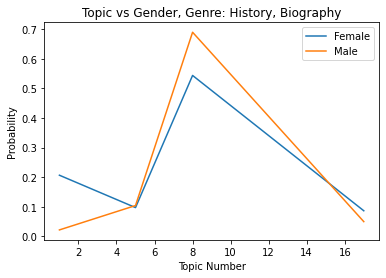

In [173]:
keys = [i[0] for i in h_female_tp]
values_1 = [i[1] for i in h_female_tp]
values_2 = [i[1] for i in h_male_tp]


df = pd.DataFrame({'Female': values_1, 'Male': values_2}, keys)
df.plot().set(xlabel='Topic Number', ylabel='Probability', title='Topic vs Gender, Genre: History, Biography')

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Text(0.5, 0, 'Topic Number'),
 Text(0, 0.5, 'Probability'),
 Text(0.5, 1.0, 'Topic vs Gender, Genre: Mystery, Thriller, Crime')]

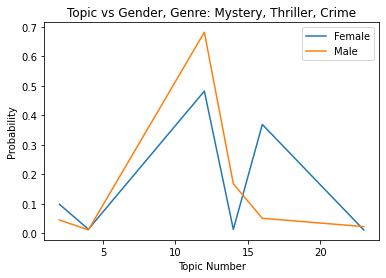

In [174]:
keys = [i[0] for i in mtc_female_tp]
values_1 = [i[1] for i in mtc_female_tp]
values_2 = [i[1] for i in mtc_male_tp]


df = pd.DataFrame({'Female': values_1, 'Male': values_2}, keys)
df.plot().set(xlabel='Topic Number', ylabel='Probability', title='Topic vs Gender, Genre: Mystery, Thriller, Crime')

### Topic Vs Upvotes

In [139]:
train_balanced_reviews_m = train_balanced_reviews_h.loc[train_balanced_reviews_h['gender'] == "male"]
train_balanced_reviews_f = train_balanced_reviews_h.loc[train_balanced_reviews_h['gender'] == "female"]

total_avg_m = sum( map(len, train_balanced_reviews_m['review_text']) ) / len(train_balanced_reviews_m['review_text'])
total_avg_f = sum( map(len, train_balanced_reviews_f['review_text']) ) / len(train_balanced_reviews_f['review_text'])
total_avg_m, total_avg_f

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(609.55743, 569.03633)

In [140]:
train_balanced_reviews_m = train_balanced_reviews_mtc.loc[train_balanced_reviews_mtc['gender'] == "male"]
train_balanced_reviews_f = train_balanced_reviews_mtc.loc[train_balanced_reviews_mtc['gender'] == "female"]

total_avg_m = sum( map(len, train_balanced_reviews_m['review_text']) ) / len(train_balanced_reviews_m['review_text'])
total_avg_f = sum( map(len, train_balanced_reviews_f['review_text']) ) / len(train_balanced_reviews_f['review_text'])
total_avg_m, total_avg_f

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(542.01288, 436.10624)

In [141]:
train_balanced_reviews_m = train_balanced_reviews_r.loc[train_balanced_reviews_r['gender'] == "male"]
train_balanced_reviews_f = train_balanced_reviews_r.loc[train_balanced_reviews_r['gender'] == "female"]

total_avg_m = sum( map(len, train_balanced_reviews_m['review_text']) ) / len(train_balanced_reviews_m['review_text'])
total_avg_f = sum( map(len, train_balanced_reviews_f['review_text']) ) / len(train_balanced_reviews_f['review_text'])
total_avg_m, total_avg_f

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(609.55743, 569.03633)